# Ali Flu Project 10x - Blood Samples from P04, P05 and P11 (Year 1 and Year 2) without integration
* Hailong

In [1]:
## load libraries ####
rm(list=ls())
start_time <- Sys.time()
suppressPackageStartupMessages(library("dplyr"))
suppressPackageStartupMessages(library("ggplot2"))
suppressPackageStartupMessages(library("Seurat"))
suppressPackageStartupMessages(library("cowplot"))
suppressPackageStartupMessages(library("pheatmap"))
suppressPackageStartupMessages(library("RColorBrewer"))
suppressPackageStartupMessages(library("Matrix"))
suppressPackageStartupMessages(library("alakazam"))
suppressPackageStartupMessages(library("tidyr"))
suppressPackageStartupMessages(library("gridExtra"))
suppressPackageStartupMessages(library("grid"))
suppressPackageStartupMessages(library("scales"))
sampleCat = "Blood"
path.work = file.path("D:","Storage","Ali","manuscript","supplFigures")
path.data = file.path("C:","Project","workspace", "AliFlu","10x", "data")
path.data2 = file.path("D:","Storage","Ali","10x", "Year2", "GEX", sampleCat)
setwd(path.work)
feature.cols = c("lightgray", "blue")

# Load mappings
mapping.file = file.path(path.data, "data_mapping", "map_GEX.txt")
mappings = read.delim(mapping.file, stringsAsFactors = FALSE, as.is=T)
mappings = filter(mappings, (SampleType == "IgD-BCell" | SampleType == "PBMC" | SampleType == "PBMC-ASC"))
dim(mappings)

[1] 38  8

In [2]:
# load saved meta pulled from Ensembl 93 using biomaRt
load(file.path(path.data, "QC_features_meta.RData"))

# CellRanger will always return the same number of features in the GEX matrix 
# as long as the same 10x reference is used 
# In this case, for the reference I used, it's 33538 features
dim(features_meta)
#[1] 33538     5

# biotypes of features
# The IG_ and TR_ ones are the ones to exclude
table(features_meta[["gene_biotype"]])
 
# get a vector of IG and TR genes 
# do this by subsetting $gene_biotype (as opposed to basing off gene names)
biotypes_excl = unique(features_meta[["gene_biotype"]])[grepl(pattern="^IG_|^TR_", x=unique(features_meta[["gene_biotype"]]))]
remove.genes = features_meta[["external_gene_name"]][features_meta[["gene_biotype"]] %in% biotypes_excl]

[1] 33538     5


      antisense       IG_C_gene IG_C_pseudogene       IG_D_gene       IG_J_gene 
           5497              14               9              37              18 
IG_J_pseudogene       IG_V_gene IG_V_pseudogene         lincRNA  protein_coding 
              3             144             188            7484           19912 
      TR_C_gene       TR_D_gene       TR_J_gene TR_J_pseudogene       TR_V_gene 
              6               4              79               4             106 
TR_V_pseudogene 
             33 

## Read in data and apply filters¶

In [3]:
obj_list <- list()
gene_use=c()
for(samplePath in mappings$SamplePath){     
    sample = mappings$SampleName[which(mappings$SamplePath == samplePath)]
    sample2 = mappings$SampleName2[which(mappings$SamplePath == samplePath)]
    sampleType = mappings$SampleType[which(mappings$SamplePath == samplePath)]
    day = mappings$Day[which(mappings$SamplePath == samplePath)]
    subject = mappings$Subject[which(mappings$SamplePath == samplePath)]
    cat(sample, '\n')    
    dir.name.full = paste0(path.data, samplePath,"/outs/filtered_feature_bc_matrix")
    cat(dir.name.full, '\n')
    data <- Read10X(data.dir = dir.name.full)
    obj <- CreateSeuratObject(counts = data, project = sample, min.cells = 5, min.features = 400)
    obj$sampleName <- sample
    obj$sampleName2 <- sample2
    obj$sampleType <- sampleType
    obj$day <- day
    obj$subject <- subject
    
    #colnames(data) <- sapply(colnames(data), function(x) paste(sample, x, sep = '_'))
    obj <- RenameCells(object = obj, add.cell.id = sample)
    obj[["percent.mt"]] <- PercentageFeatureSet(object = obj, pattern = "^MT-")
    gene.cutoff.high=7000
    obj <- subset(x = obj, subset = nFeature_RNA > 400 & nFeature_RNA < gene.cutoff.high & percent.mt < 15)
  
    obj <- NormalizeData(object = obj, normalization.method = "LogNormalize", scale.factor = 10000)
    obj_list[[sample]] <- obj
    
}


P04_IgD-BCell_d0_1_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d0_PBMC-lib1/outs/filtered_feature_bc_matrix 
P04_IgD-BCell_d0_1_Y2 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WUs321-04-s0_PBMC-lib1/outs/filtered_feature_bc_matrix 
P04_IgD-BCell_d12_1_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d12_PBMC-lib1/outs/filtered_feature_bc_matrix 
P04_IgD-BCell_d14_1_Y2 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WUs321-04-s14_PBMC-lib1/outs/filtered_feature_bc_matrix 
P04_IgD-BCell_d90_1_Y2 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WUs321-04-s90_PBMC-lib1/outs/filtered_feature_bc_matrix 
P04_IgD-BCell_d120_1_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d120_PBMC-lib1/outs/filtered_feature_bc_matrix 
P04_PBMC-ASC_d5_1_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d5_PBMC_ASC-lib1/outs/filtered_feature_bc_matrix 
P04_PBMC-AS

## Read in data and apply filters¶

In [4]:
samples = mappings$SampleName
samples.left = samples[-c(1,2)]
immune.combined <- merge(obj_list[[samples[1]]] , obj_list[[samples[2]]])
for(sample in samples.left){
    immune.combined <- merge(immune.combined ,  obj_list[[sample]])
}
# remove obj_list & obj & data to save space
rm(obj)
rm(data)
rm(obj_list)
gc()


used       (Mb)   gc trigger (Mb)    max used   (Mb)   
Ncells    7574604  404.6   13004421   694.6   11151421   595.6
Vcells 1168499587 8915.0 4238309304 32335.8 5297329792 40415.5

## Number of cells in each sample after filtering

In [5]:
cell.count = as.matrix(table(Idents(immune.combined)))
colnames(cell.count) = "Cell Count"
cell.count

Cell Count
P04_IgD-BCell_d0_1_Y1    9498     
P04_IgD-BCell_d0_1_Y2   10635     
P04_IgD-BCell_d12_1_Y1  10346     
P04_IgD-BCell_d120_1_Y1  9722     
P04_IgD-BCell_d14_1_Y2  10080     
P04_IgD-BCell_d90_1_Y2   8864     
P04_PBMC-ASC_d5_1_Y1    14742     
P04_PBMC-ASC_d7_1_Y2    16239     
P05_IgD-BCell_d0_1_Y1    3896     
P05_IgD-BCell_d0_1_Y2    6734     
P05_IgD-BCell_d12_1_Y1   6400     
P05_IgD-BCell_d120_1_Y1  3624     
P05_IgD-BCell_d13_1_Y2   4811     
P05_IgD-BCell_d180_1_Y1  6359     
P05_IgD-BCell_d180_2_Y1  5994     
P05_IgD-BCell_d28_1_Y1   7730     
P05_IgD-BCell_d28_1_Y2   3129     
P05_IgD-BCell_d5_1_Y1    3249     
P05_IgD-BCell_d6_1_Y2    4492     
P05_IgD-BCell_d60_1_Y1   3053     
P05_IgD-BCell_d60_1_Y2   5720     
P05_IgD-BCell_d90_1_Y1   2927     
P05_IgD-BCell_d90_1_Y2   7143     
P05_IgD-BCell_d90_2_Y1   2811     
P05_PBMC_d0_2_Y1         7662     
P05_PBMC_d12_2_Y1        6675     
P05_PBMC_d120_1_Y1       5764     
P05_PBMC_d28_2_Y1        6278     
P05_PBMC_d5_2_Y1         6968     
P05_PBMC_d60_1_Y1        7430     
P11_IgD-BCell_d0_1_Y1    7162     
P11_IgD-BCell_d0_1_Y2    6022     
P11_IgD-BCell_d120_1_Y1  7791     
P11_IgD-BCell_d35_1_Y1   7181     
P11_IgD-BCell_d35_1_Y2   6396     
P11_IgD-BCell_d90_1_Y2   6636     
P11_PBMC-ASC_d6_1_Y1     7564     
P11_PBMC-ASC_d6_1_Y2     6423

Warning message:
"The following arguments are not used: do.plot"


After remvoing IG/TR genes, total gene count is:  1696 


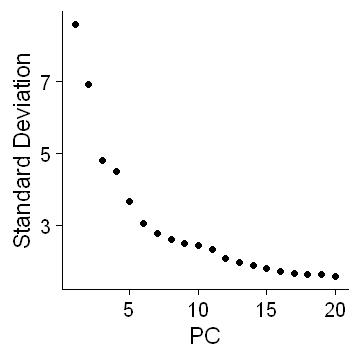

In [6]:
# Run the standard workflow for visualization and clustering
immune.combined <- ScaleData(object = immune.combined, verbose = FALSE)
immune.combined <- FindVariableFeatures(immune.combined, selection.method = "vst", nfeatures = 2000, do.plot = F)
bool.remove.genes <- immune.combined@assays$RNA@var.features %in% remove.genes
immune.combined@assays$RNA@var.features = immune.combined@assays$RNA@var.features[!bool.remove.genes]                     
cat('After remvoing IG/TR genes, total gene count is: ', length(immune.combined@assays$RNA@var.features), '\n')
immune.combined <- RunPCA(object = immune.combined, npcs = 30, verbose = FALSE)
options(repr.plot.width=3, repr.plot.height=3)
ElbowPlot(object = immune.combined)

In [7]:
# UMAP and Clustering
immune.combined <- RunUMAP(object = immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindNeighbors(object = immune.combined, reduction = "pca", dims = 1:20)
saveRDS(immune.combined, file.path(path.work, "Blood.GEX.Y1Y2.beforeCluster.rds"))

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
11:49:48 UMAP embedding parameters a = 0.9922 b = 1.112

11:49:48 Read 264150 rows and found 20 numeric columns

11:49:48 Using Annoy for neighbor search, n_neighbors = 30

11:49:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:50:22 Writing NN index file to temp file C:\Users\hm287\AppData\Local\Temp\2\Rtmpiw3Z8G\file26da02cb4228

11:50:22 Searching Annoy index using 1 thread, search_k = 3000

11:52:23 Annoy recall = 100%

11:52:28 Commencing smooth kNN distance calibration using 1 

In [42]:
immune.combined = readRDS("Blood.GEX.Y1Y2.beforeCluster.rds")
immune.combined <- FindClusters(immune.combined, resolution = 0.2)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 264150
Number of edges: 6854691

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9499
Number of communities: 16
Elapsed time: 166 seconds


1 singletons identified. 15 final clusters.



In [10]:
#options(repr.plot.width=6, repr.plot.height=3.5)
# visualize results of CCA plot CC1 versus CC2 and look at a violin plot
#DimPlot(object = immune.combined, reduction = "umap", group.by = "sampleName")

In [11]:
#options(repr.plot.width=6, repr.plot.height=5)
#DimPlot(object = immune.combined, reduction = "umap", group.by = "sampleType", split.by="sampleType")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



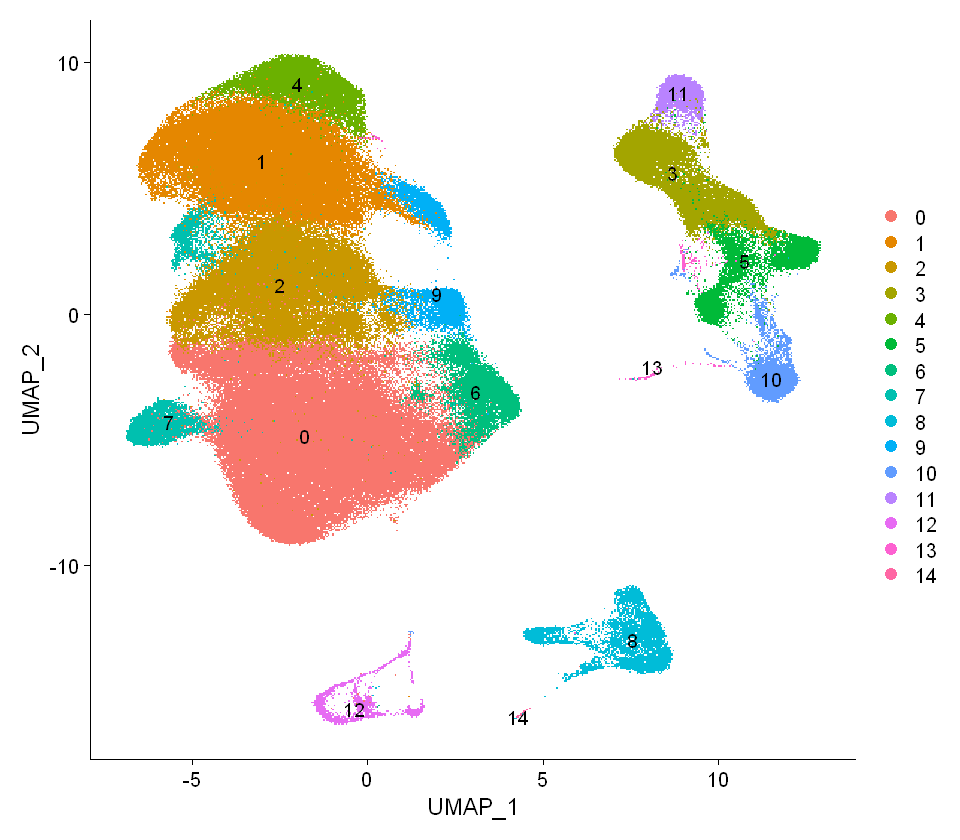

In [43]:
options(repr.plot.width=8, repr.plot.height=7)
DimPlot(object = immune.combined, reduction = "umap", label = TRUE)

In [48]:
pdf("UMAP_Blood_beforeAnnotation.pdf", width=5, height=4, useDingbats=FALSE)
DimPlot(object = immune.combined, reduction = "umap", label = FALSE)
dev.off()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



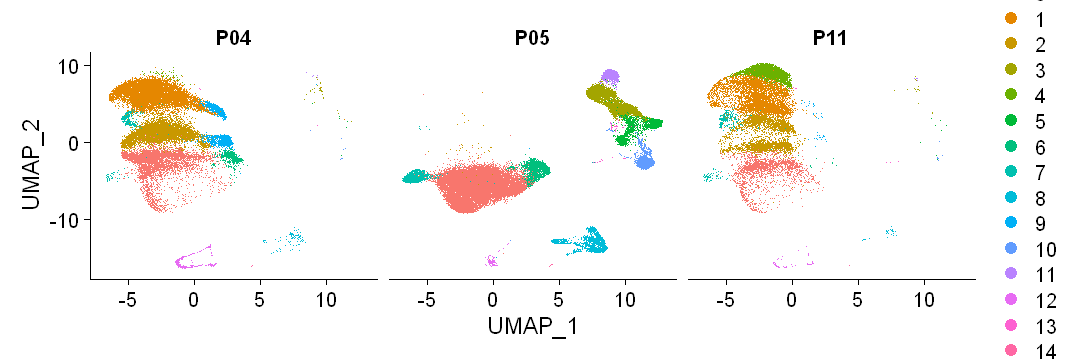

In [44]:
options(repr.plot.width=9, repr.plot.height=3)
DimPlot(object = immune.combined, reduction = "umap", split.by = "subject")

In [51]:
pdf("UMAP_Blood_beforeAnnotation_bySubject.pdf", width=12, height=4, useDingbats=FALSE)
DimPlot(object = immune.combined, reduction = "umap", split.by = "subject")
dev.off()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

## Check marker genes

In [45]:
B <- c("MS4A1", "IGKC","CD79A", "CD79B", "CD19")
RMB <- c("TNFRSF13B", "CD27", "CD24") #Resting Memory B
naive.B <- c("TCL1A", "IL4R",  "CCR7", "IGHM", "IGHD") #Naive B
plasma <- c("CD38", "CD27","FKBP11","TRIB1","SDC1","XBP1", "IRF4", "SEC11C", "JCHAIN", "PRDM1")
GC.B <- c("BCL6", "RGS13", "MEF2B", "STMN1", "ELL3", "SERPINA9")
ABC <- c("TBX21", "FCRL5", "ITGAX", "NKG7", "ZEB2", "CR2")# the lack of CR2 for activated B cells (ABCs);
T <- c("CD3D", "CD3E","CD4", "IL7R", "CD8A")
NK <- c("GZMB", "GNLY", "NKG7", "NCAM1")
CD14.Monocyte <-c("CD14","LYZ")
DC <- c("FCER1A", "CST3")
platlet <- "PPBP"
dividing  <- c("MKI67", "CDK1") # Dividing cells 
  
all.markers = unique(c(B, RMB, naive.B, plasma, GC.B, ABC, T, NK, CD14.Monocyte, DC, platlet, dividing))
#MS4A1, CD19 and CD79A for B cells; CD3D, CD3E, CD3G, IL7R and CD4 or CD8A for CD4+ or CD8+ T cells; 
# GZMB, GNLY, NKG7 and NCAM1 for natural killer (NK) cells; CD14, LYZ, CST3 and MS4A7 for monocytes; 
# IL3RA and CLEC4C for plasmacytoid dendritic cells; and PPBP 
markers = c("MS4A1", "CD19","CD79A", "CD3D", "CD3E", "CD3G", "IL7R","CD4","CD8A","GZMB", "GNLY", "NKG7",
    "NCAM1", "CD14", "LYZ", "CST3", "MS4A7","IL3RA", "CLEC4","PPBP")        

Warning message in FetchData(object = object, vars = features, cells = cells):
"The following requested variables were not found: CLEC4"


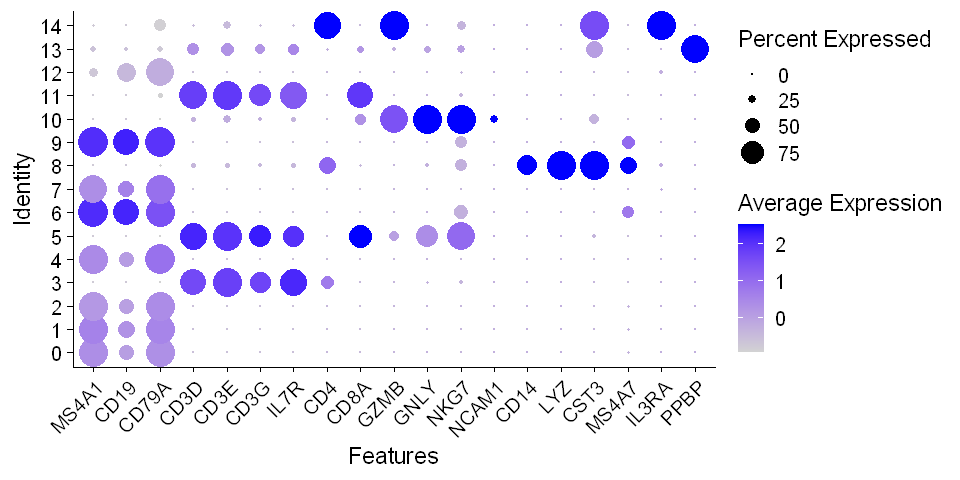

In [46]:
options(repr.plot.width=8, repr.plot.height=4)
DotPlot(immune.combined, assay = "RNA", features =  unique(markers), dot.scale = 8) + RotatedAxis()

In [54]:
pdf("DotPlot_Blood_beforeAnnotation.pdf", width=7, height=4, useDingbats=FALSE)
DotPlot(immune.combined, assay = "RNA", features =  unique(markers), dot.scale = 5) + RotatedAxis()
dev.off()

Warning message in FetchData(object = object, vars = features, cells = cells):
"The following requested variables were not found: CLEC4"


png 
  2

### B cell markers

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



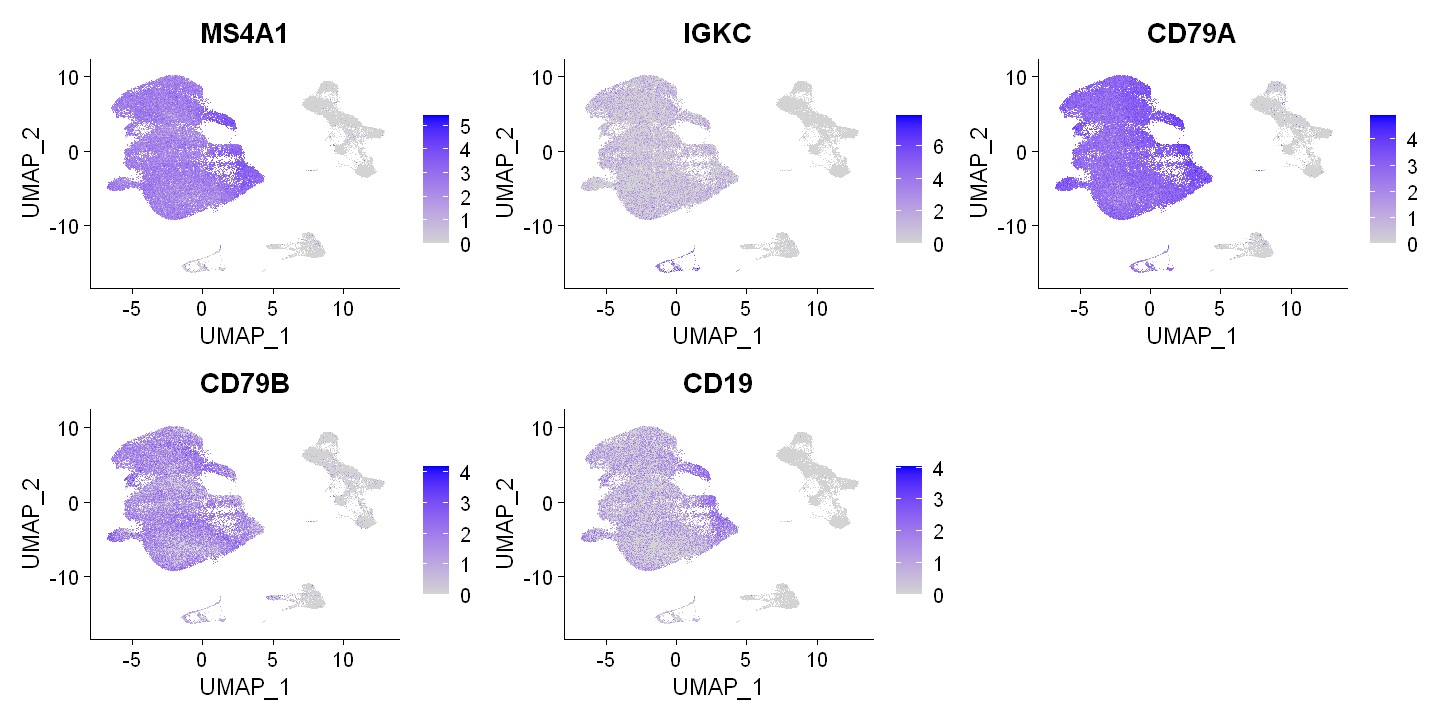

In [16]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = B, ncol =3,cols = feature.cols, min.cutoff = 0)

### Plasma markers

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To di

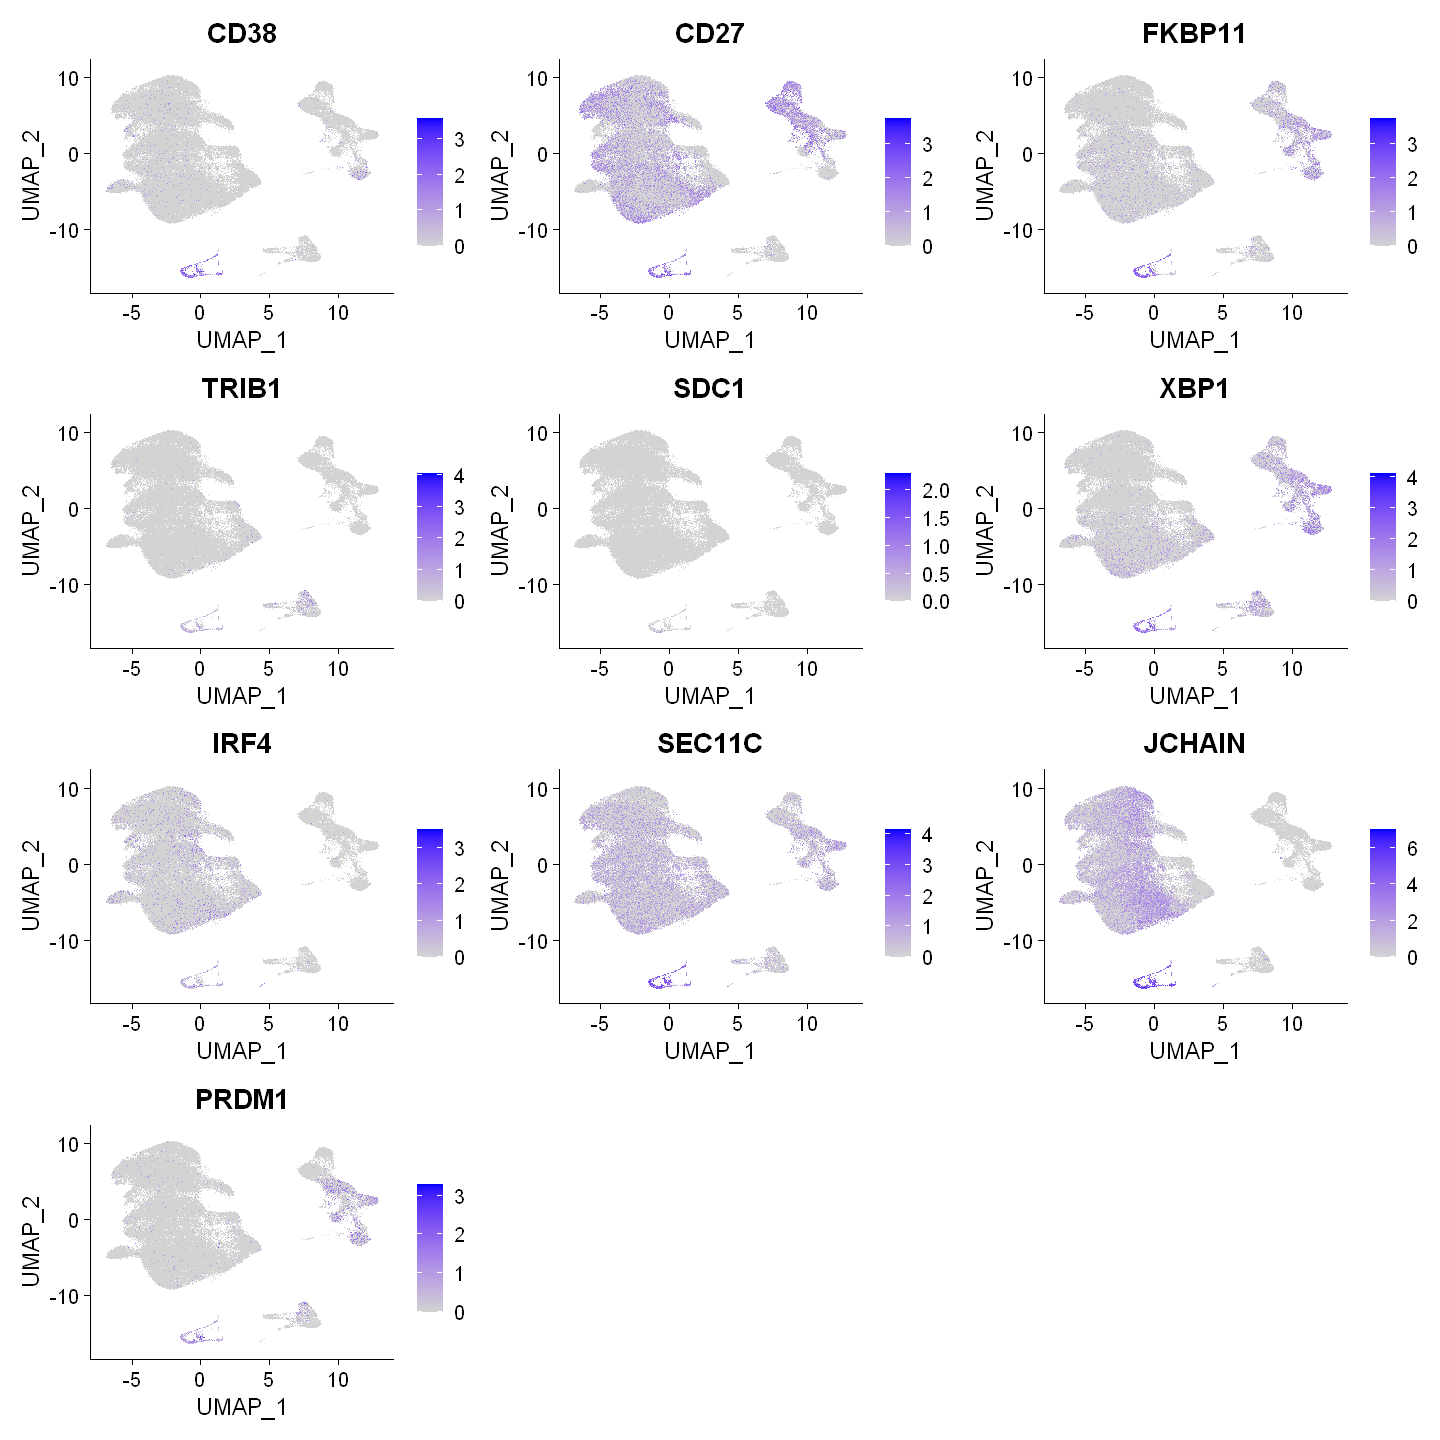

In [17]:
options(repr.plot.width=12, repr.plot.height=12)
FeaturePlot(object = immune.combined, features = plasma, ncol =3,cols = feature.cols, min.cutoff = 0)

### Resting Memory B cells

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



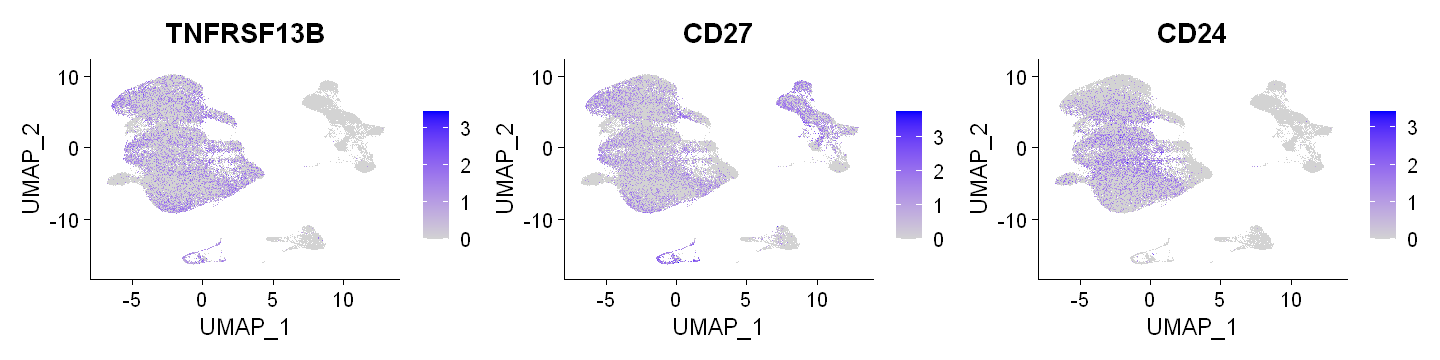

In [18]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = RMB, ncol =3,cols = feature.cols, min.cutoff = 0)

### Naive B cells

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



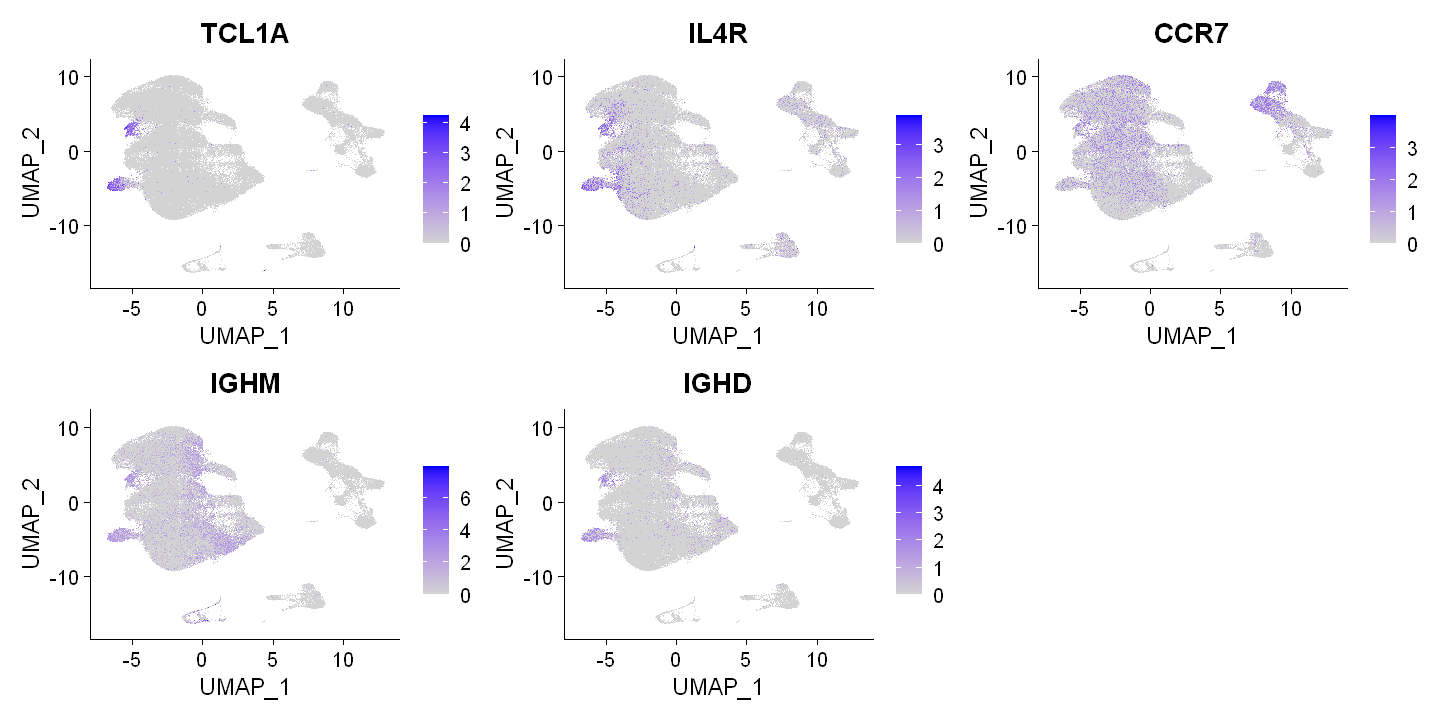

In [19]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = naive.B, ncol =3,cols = feature.cols, min.cutoff = 0)

### Germinal Center B cells

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



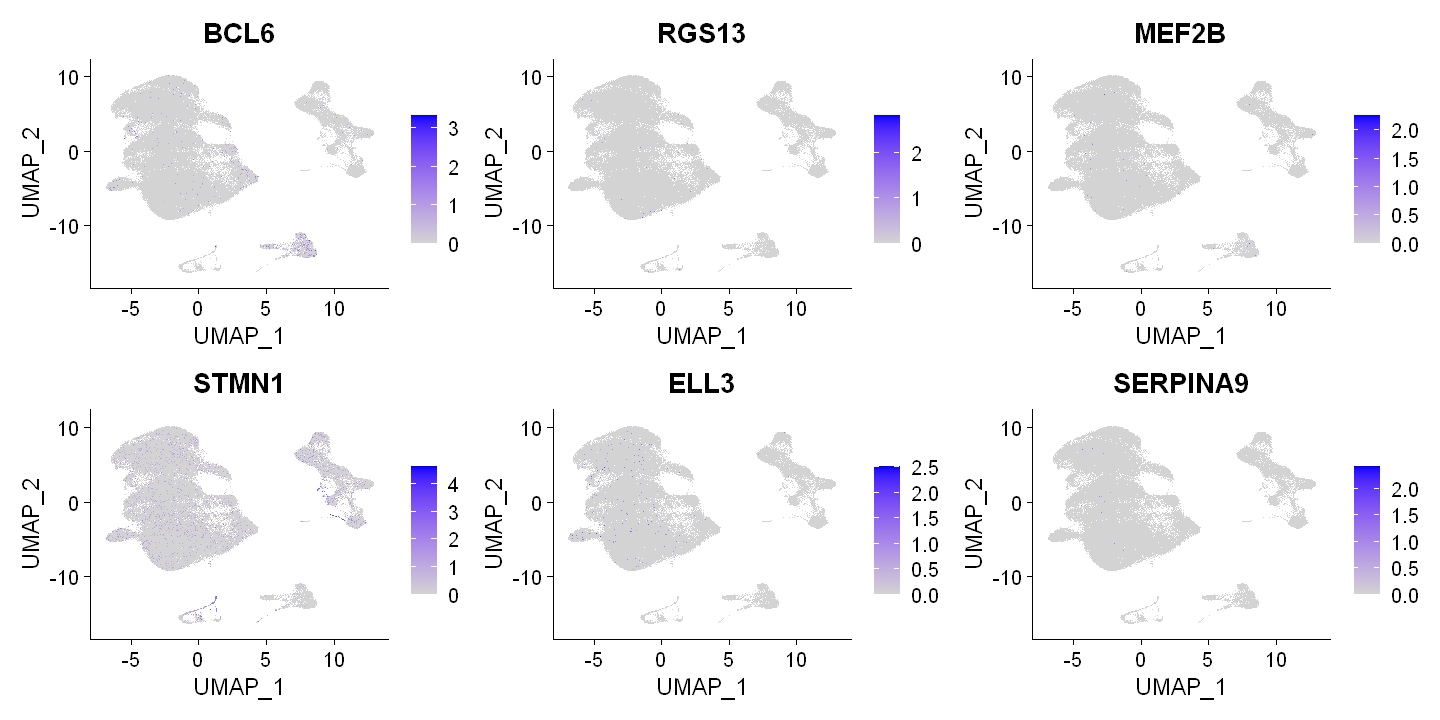

In [20]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = GC.B, ncol =3,cols = feature.cols, min.cutoff = 0)

### Activated B cells

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



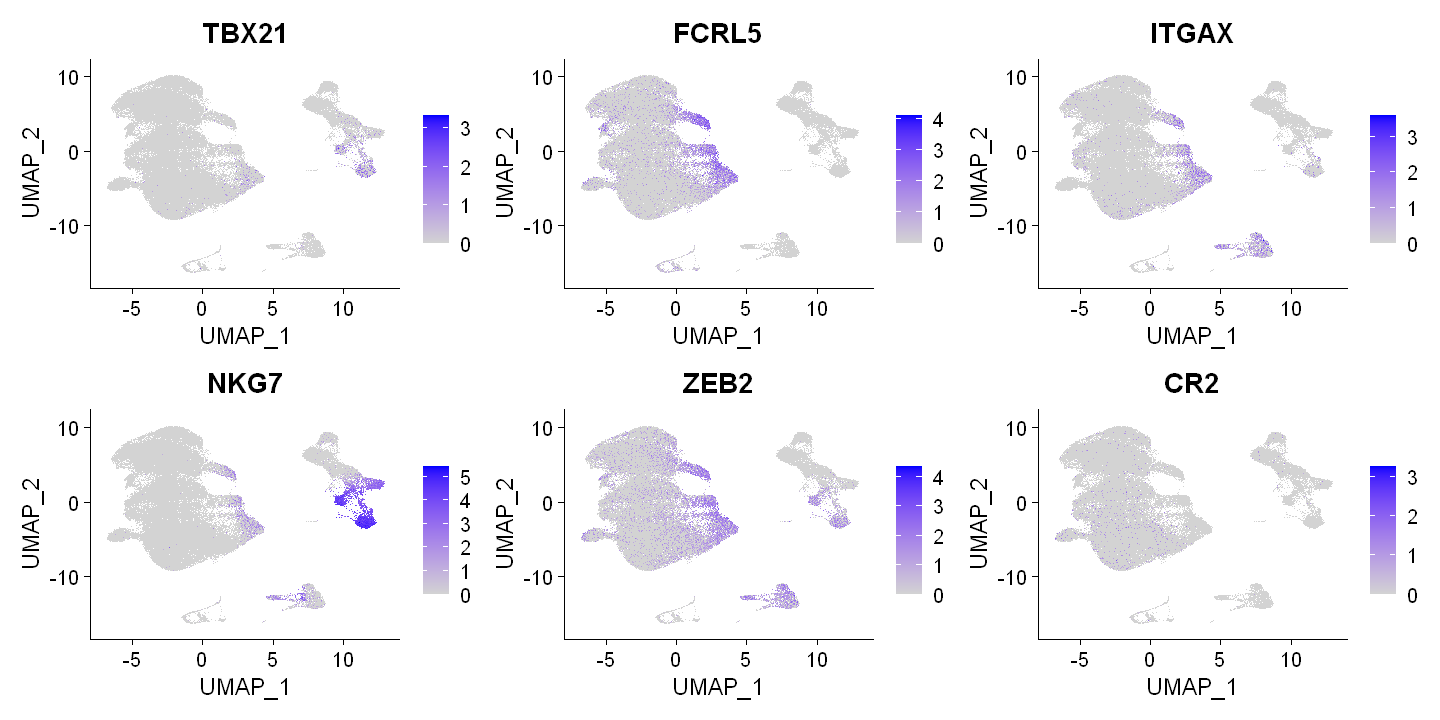

In [21]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = ABC, ncol =3,cols = feature.cols, min.cutoff = 0)

### T cell markers

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



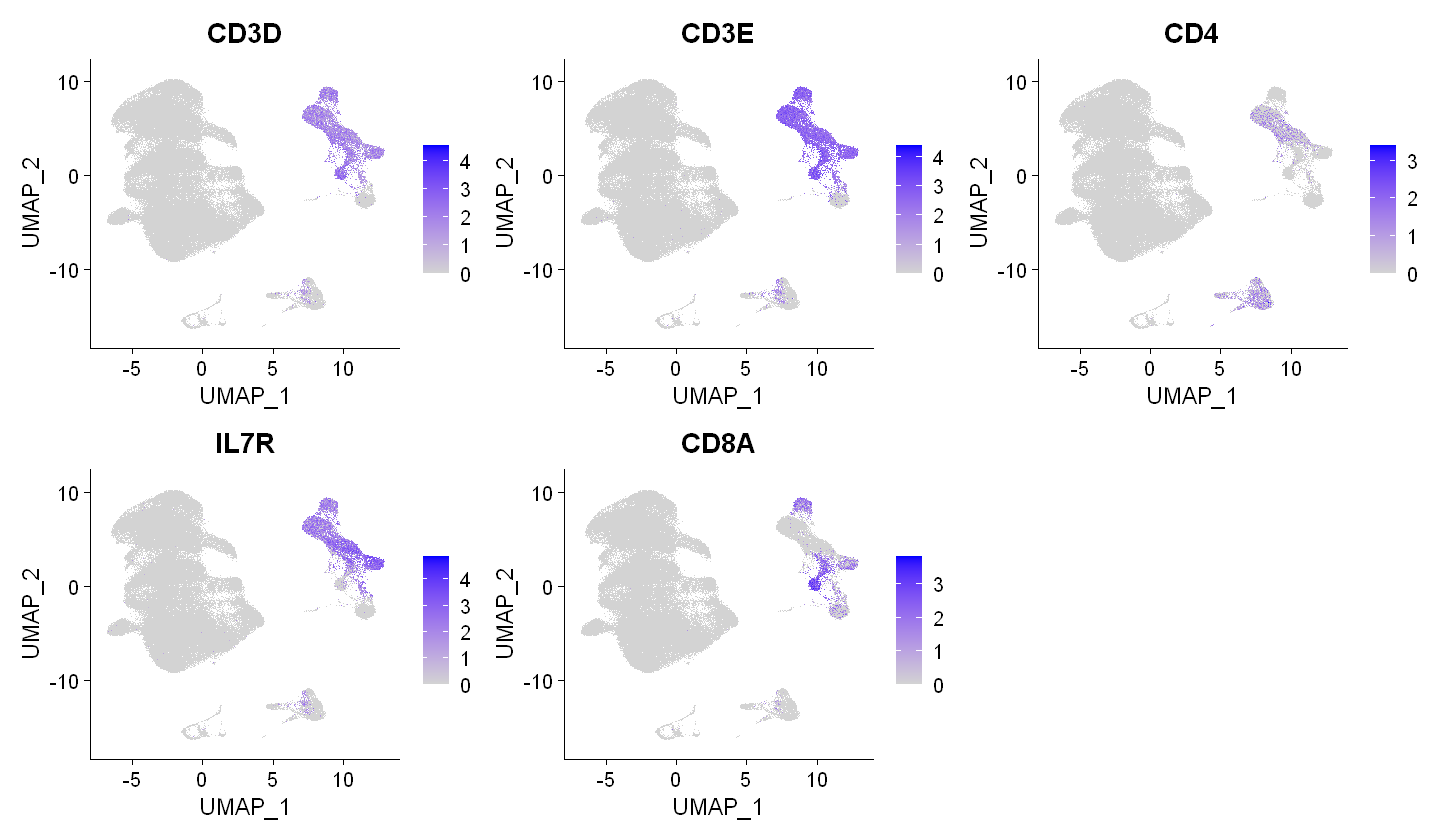

In [22]:
options(repr.plot.width=12, repr.plot.height=7)
FeaturePlot(object = immune.combined, features = T, ncol =3,cols = feature.cols, min.cutoff = 0)

### NK cell markers

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



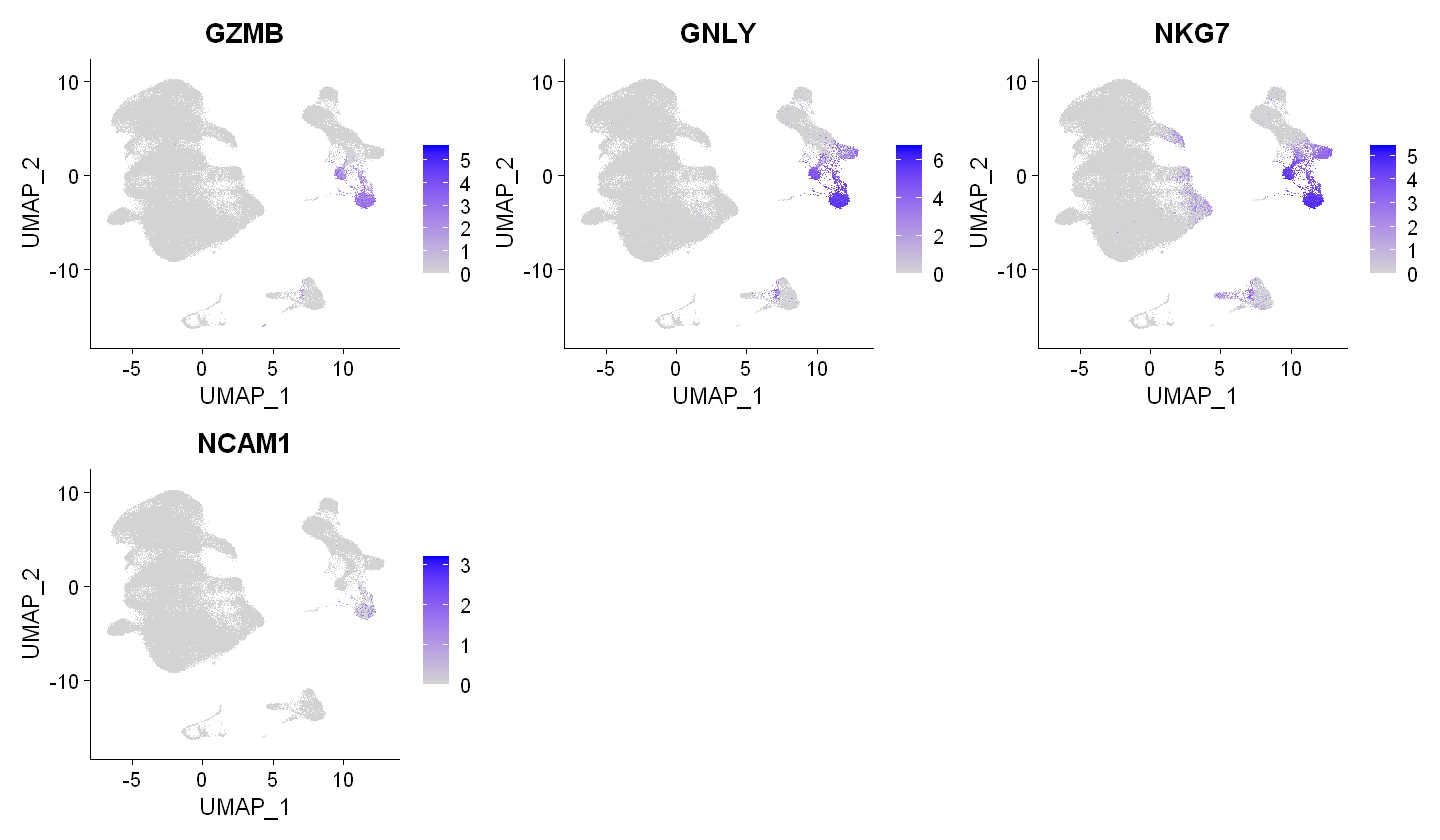

In [23]:
options(repr.plot.width=12, repr.plot.height=7)
FeaturePlot(object = immune.combined, features = NK, ncol =3,cols = feature.cols, min.cutoff = 0)

### DC cell markers

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



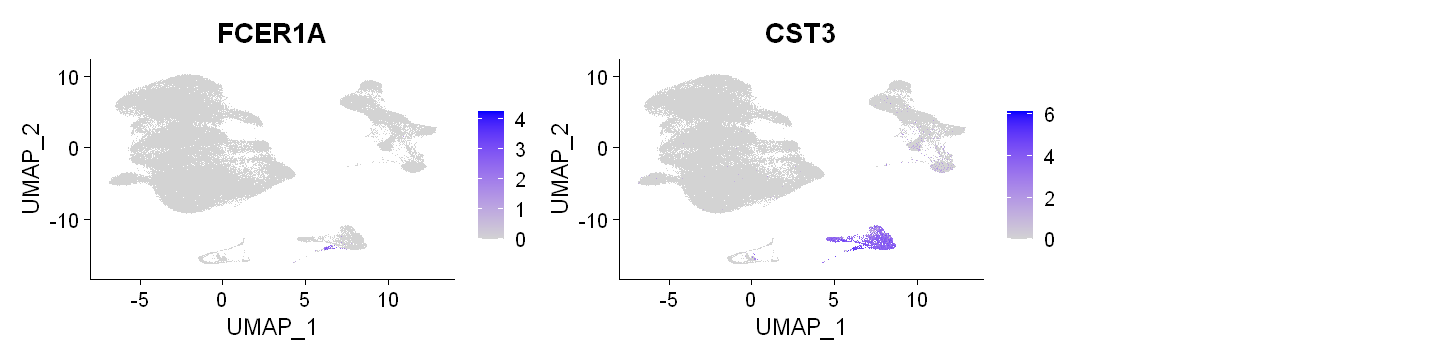

In [24]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = DC, ncol =3,cols = feature.cols, min.cutoff = 0)

### CD14 Monocyte

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



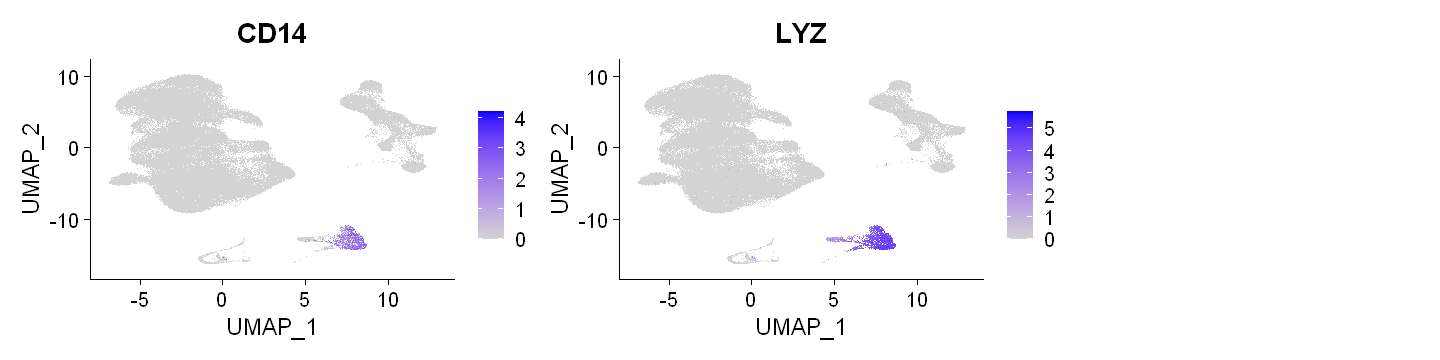

In [25]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = CD14.Monocyte, ncol =3,cols = feature.cols, min.cutoff = 0)

### Platlet

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



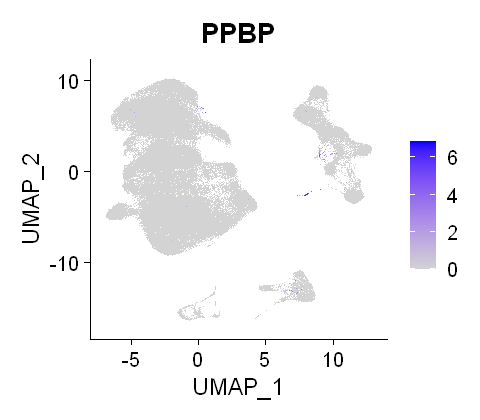

In [26]:
options(repr.plot.width=4, repr.plot.height=3.5)
FeaturePlot(object = immune.combined, features = platlet, cols = feature.cols, min.cutoff = 0)
 

### Dividing cells

In [55]:
# save for future use
saveRDS(immune.combined, file.path(path.work, "Blood.GEX.Y1Y2.rds"))
#immune.combined <- readRDS("Blood.GEX.rds")

In [30]:
path.data = file.path("D:","Storage","Ali","10x","Year2","mergeBCR_Y1Y2","data")
BCR.Y1Y2.P04 = read.table(paste0(path.data, "/P04_p.tsv"), header=TRUE, sep="\t",as.is=T,stringsAsFactors = FALSE)
BCR.Y1Y2.P05 = read.table(paste0(path.data, "/P05_p.tsv"), header=TRUE, sep="\t",as.is=T,stringsAsFactors = FALSE)

BCR.Y1Y2.P04 = BCR.Y1Y2.P04 %>% 
        dplyr::filter((SAMPLETYPE == "IgD-BCell" | SAMPLETYPE == "PBMC" | SAMPLETYPE == "PBMC-ASC")  
                      & DATATYPE == "singleCell") 
BCR.Y1Y2.P05 = BCR.Y1Y2.P05 %>% 
        dplyr::filter((SAMPLETYPE == "IgD-BCell" | SAMPLETYPE == "PBMC" | SAMPLETYPE == "PBMC-ASC") 
                      & DATATYPE == "singleCell")
BCR.Y1Y2 = rbind(BCR.Y1Y2.P04, BCR.Y1Y2.P05)

In [43]:
BCR.Y1Y2$CELL = as.character(BCR.Y1Y2$CELL)
BCR.Y1Y2 = BCR.Y1Y2 %>% rowwise() %>%
            mutate(BARCODE = paste(SAMPLE, strsplit(CELL, split = "-")[[1]][1], sep = "_"))

b_cell.BM <- unique((BCR.Y1Y2 %>%
            filter(BARCODE %in% Cells(immune.combined)))$BARCODE)

length(b_cell.BM)
 

[1] 120251

In [56]:
 levels(x = immune.combined)

[1] "0"  "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14"

In [57]:
# somehow the ident sorted in the order of 0,1,10,11,...,19,2,20,21,22,3,4,5,6,7,8,9 ,so need to change new.cluster.ids order to
# 14: pDC 8: monocyte 13: platelet 10:NK 5+11: CD8 3:CD4 0,1,2,4,6,7,9,12:B
new.cluster.ids <- c("B", "B","B", "CD4+ T", "B", "CD8+ T", "B","B", "Monocyte","B",
                     "NK", "CD8+ T", "B", "Platelet","pDC"                   
                     )
names(x = new.cluster.ids) <- levels(x = immune.combined)

In [58]:
immune.combined <- RenameIdents(object = immune.combined, new.cluster.ids)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



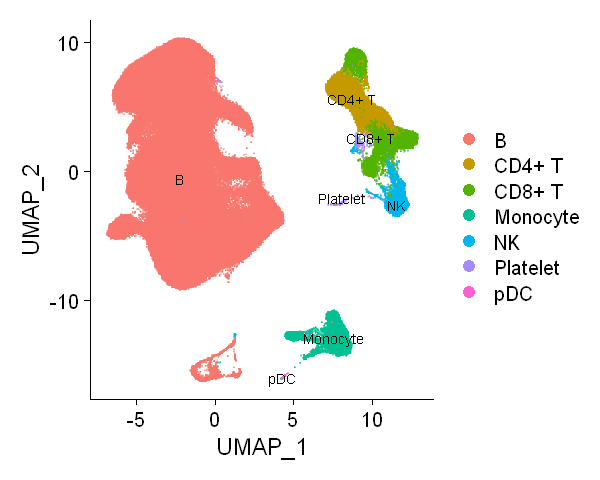

In [59]:
options(repr.plot.width=5, repr.plot.height=4)
DimPlot(object = immune.combined, reduction = "umap", label = TRUE, pt.size = 0.8,label.size=3) 

In [60]:
pdf("UMAP_Blood.pdf", width=5, height=4, useDingbats=FALSE)
DimPlot(object = immune.combined, reduction = "umap", label = FALSE)
dev.off()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

In [61]:
pdf("UMAP_Blood_bySubject.pdf", width=12, height=4, useDingbats=FALSE)
DimPlot(object = immune.combined, reduction = "umap", split.by = "subject")
dev.off()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

In [62]:
pdf("DotPlot_Blood.pdf", width=7, height=4, useDingbats=FALSE)
DotPlot(immune.combined, assay = "RNA", features =  unique(markers), dot.scale = 5) + RotatedAxis()
dev.off()

Warning message in FetchData(object = object, vars = features, cells = cells):
"The following requested variables were not found: CLEC4"


png 
  2

In [63]:
# save for future use
saveRDS(immune.combined, file.path(path.work, paste0(sampleCat,".GEX.rds")))